In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
# library for train test split
from sklearn.model_selection import train_test_split

In [4]:
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

# Load and Explore data

In [6]:
df = pd.read_csv("spam.txt", sep ='\t',names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
duplicates = df[df.duplicated()]
print(duplicates[:15])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...
444   ham                             Sorry, I'll call later
533   ham                  Gudnite....tc...practice going on
655   ham                       Did u got that persons story
658   ham               You will be in the place of that man
702   ham                             Sorry, I'll call later
768   ham                             Sorry, I'll call later
769   ham  I cant pick the phone right now. Pls send a me...
775   ham                         Just sleeping..and surfing


In [9]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

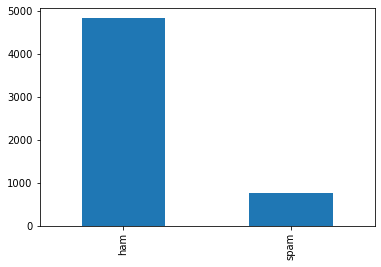

In [10]:
df.label.value_counts().plot.bar();

# Longer sms?Ham or Spam?

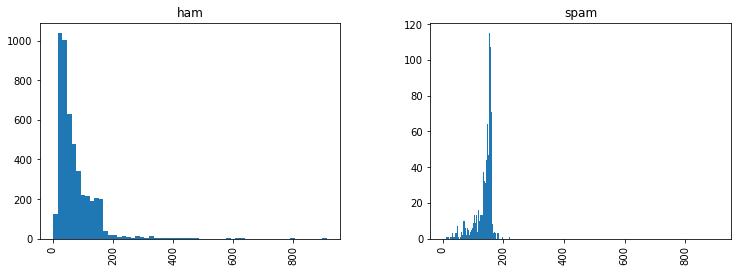

In [24]:
df['length'] = df['message'].apply(len)
df.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

In [26]:
#Majority of the spam texts are longer than ham
ham_sms = df[df.label =='ham']
spam_sms = df[df.label=='spam']

In [27]:
#Visualize using wordcloud
ham_sms_word = " ".join(ham_sms.message.to_numpy().tolist())
spam_sms_word = " ".join(spam_sms.message.to_numpy().tolist())

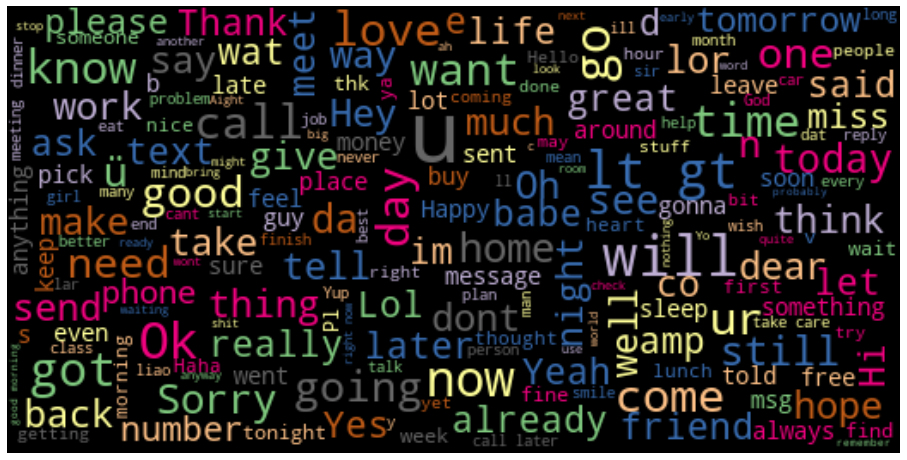

In [28]:
#wordcloud for ham sms
ham_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="Black", colormap='Accent').generate(ham_sms_word)
plt.figure(figsize=(16,10))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

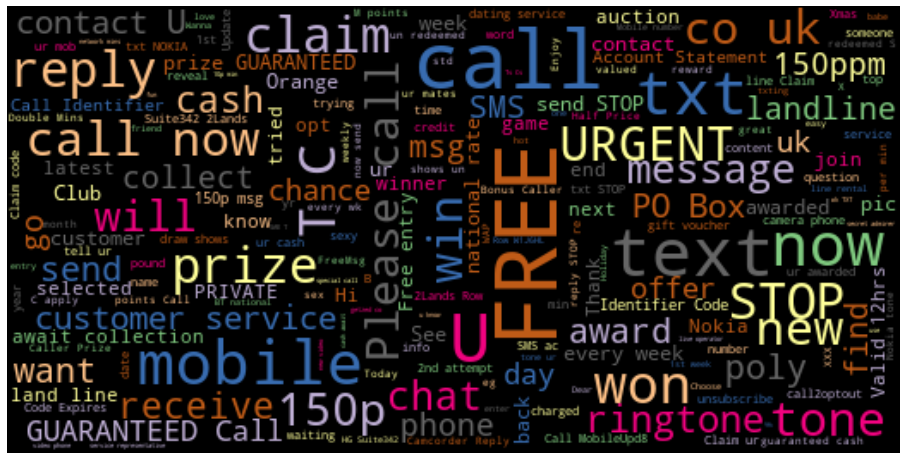

In [29]:
# wordcloud of spam texts
spam_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Accent_r').generate(spam_sms_word)
plt.figure(figsize=(16,10))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

C:\Users\Radhika Roger\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


15.481865284974095

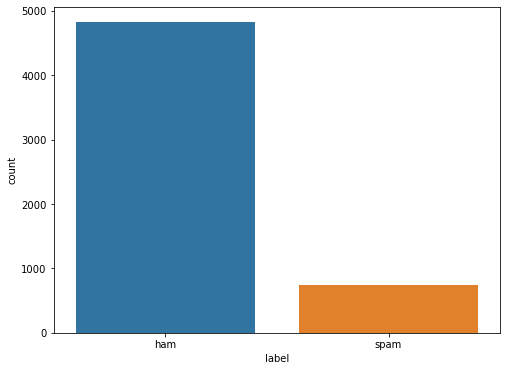

In [30]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
(len(spam_sms)/len(ham_sms))*100 

In [31]:
ham_sms_data = ham_sms.sample(n = len(spam_sms), random_state = 44)
spam_sms_data = spam_sms
print(ham_sms_data.shape, spam_sms_data.shape)

(747, 3) (747, 3)


C:\Users\RADHIK~1\AppData\Local\Temp/ipykernel_7384/1812785305.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sms_data = ham_sms_data.append(spam_sms_data).reset_index(drop=True)
C:\Users\Radhika Roger\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'sms types')

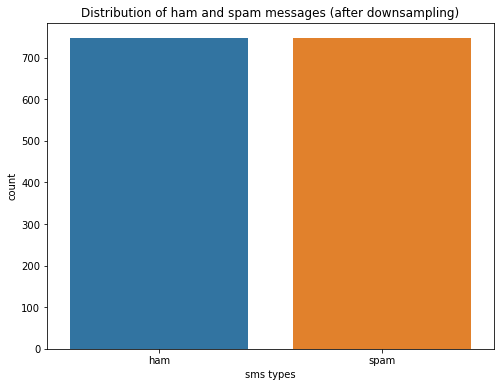

In [19]:
sms_data = ham_sms_data.append(spam_sms_data).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(sms_data.label)
plt.title('Distribution of ham and spam messages (after downsampling)')
plt.xlabel('sms types')

In [32]:
sms_data['text_length'] = sms_data['message'].apply(len)
labels = sms_data.groupby('label').mean()
labels

,length,text_length,sms_type
label,,,
ham,73.238286,73.238286,0.0
spam,138.670683,138.670683,1.0


In [33]:
sms_data['sms_type']= sms_data['label'].map({'ham': 0, 'spam': 1})
sms_label = sms_data['sms_type'].values

# Split data into train and test


In [34]:
train_sms, test_sms, train_label, test_label = train_test_split(sms_data['message'], sms_label, test_size=0.2, random_state=434)

In [35]:
max_len = 50 
trunc_type = "post" 
pad_type = "post" 
oov_tok = "<OOV>" 
voc_size = 500

In [39]:
tknizer = Tokenizer(num_words = voc_size, char_level=False, oov_token = oov_tok)
tknizer.fit_on_texts(train_sms)

In [40]:
word_index = tknizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [41]:
total_words = len(word_index)
print('%s unique tokens in training data. ' % total_words)

4169 unique tokens in training data. 


# Tokenization,Sequencing and Padding

In [52]:
train_seq = tknizer.texts_to_sequences(train_sms)
train_pad = pad_sequences (train_seq, maxlen = max_len, padding = pad_type, truncating = trunc_type )
test_seq = tknizer.texts_to_sequences(test_sms)
test_pad = pad_sequences(test_seq, maxlen = max_len,
padding = pad_type, truncating = trunc_type)

In [53]:
print('Shape of training tensor: ', train_pad.shape)
print('Shape of testing tensor: ', test_pad.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [54]:
len(train_seq[0]), len(train_seq[1])

(27, 24)

In [55]:
len(train_pad[0]), len(train_pad[1])

(50, 50)

In [56]:
print(train_pad[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [57]:
voc_size = 500 
emb_dim = 16
drop_value = 0.2 
n_dense = 24

In [58]:
#Dense model architecture
dense_model = Sequential()
dense_model.add(Embedding(voc_size, emb_dim, input_length=max_len))
dense_model.add(GlobalAveragePooling1D())
dense_model.add(Dense(24, activation='relu'))
dense_model.add(Dropout(drop_value))
dense_model.add(Dense(1, activation='sigmoid'))

In [59]:
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [60]:
dense_model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [61]:
num_epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = dense_model.fit(train_pad, train_label, epochs=num_epochs, validation_data=(test_pad, test_label),callbacks =[early_stopping], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6849 - accuracy: 0.6837 - val_loss: 0.6747 - val_accuracy: 0.7592
Epoch 2/30
38/38 - 0s - loss: 0.6588 - accuracy: 0.7858 - val_loss: 0.6380 - val_accuracy: 0.8194
Epoch 3/30
38/38 - 0s - loss: 0.6078 - accuracy: 0.8427 - val_loss: 0.5751 - val_accuracy: 0.8127
Epoch 4/30
38/38 - 0s - loss: 0.5352 - accuracy: 0.8494 - val_loss: 0.5010 - val_accuracy: 0.8562
Epoch 5/30
38/38 - 0s - loss: 0.4559 - accuracy: 0.8837 - val_loss: 0.4303 - val_accuracy: 0.8696
Epoch 6/30
38/38 - 0s - loss: 0.3828 - accuracy: 0.8962 - val_loss: 0.3678 - val_accuracy: 0.8796
Epoch 7/30
38/38 - 0s - loss: 0.3176 - accuracy: 0.9096 - val_loss: 0.3157 - val_accuracy: 0.8863
Epoch 8/30
38/38 - 0s - loss: 0.2701 - accuracy: 0.9255 - val_loss: 0.2741 - val_accuracy: 0.8963
Epoch 9/30
38/38 - 0s - loss: 0.2282 - accuracy: 0.9289 - val_loss: 0.2399 - val_accuracy: 0.8997
Epoch 10/30
38/38 - 0s - loss: 0.2029 - accuracy: 0.9339 - val_loss: 0.2128 - val_accuracy: 0.9164
Epoch 11/30
38/38 -

In [62]:
dense_model.evaluate(test_pad, test_label)

10/10 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9565


[0.11808089166879654, 0.95652174949646]

In [63]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

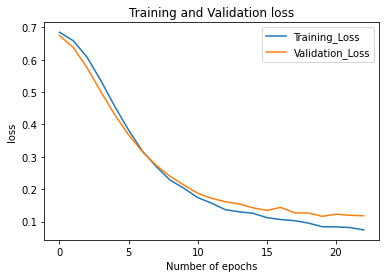

In [64]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

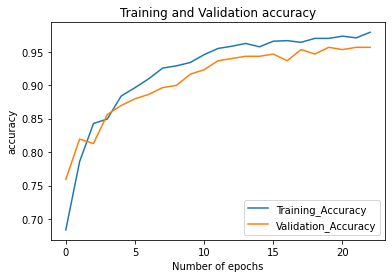

In [65]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [66]:
n_lstm = 20
drop_lstm =0.2

In [67]:
#LSTM Spam detection architecture
lstm_model = Sequential()
lstm_model.add(Embedding(voc_size, emb_dim, input_length=max_len))
lstm_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_model.add(Dense(1, activation='sigmoid'))

In [68]:
lstm_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
num_epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = lstm_model.fit(train_pad, train_label, epochs=num_epochs, validation_data=(test_pad, test_label),callbacks =[early_stopping], verbose=2)

Epoch 1/30
38/38 - 14s - loss: 0.6721 - accuracy: 0.6020 - val_loss: 0.5944 - val_accuracy: 0.6792
Epoch 2/30
38/38 - 2s - loss: 0.4031 - accuracy: 0.8398 - val_loss: 0.3605 - val_accuracy: 0.8835
Epoch 3/30


In [ ]:
# Biderectional LSTM Architecture
Bilstm_model = Sequential()
Bilstm_model.add(Embedding(voc_size, emb_dim, input_length=max_len))
Bilstm_model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
Bilstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
Bilstm_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
print(f"Dense architecture loss and accuracy: {dense_model.evaluate(test_pad, test_label)} " )
print(f"LSTM architecture loss and accuracy: {lstm_model.evaluate(test_pad, test_label)} " )
print(f"Bi-LSTM architecture loss and accuracy: {Bilstm_model.evaluate(test_pad, test_label)} " )

In [ ]:
# display long string 
pd.options.display.max_colwidth=100
df[:3]

In [46]:
predict_sms_ham_spam = ['Sorry, I’ll call later']

In [47]:
def predict_spam(predict_sms_ham_spam):
    new_seq = tknizer.texts_to_sequences(predict_sms_ham_spam)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = pad_type,
                      truncating=trunc_type)
    return (dense_model.predict(padded))
predict_spam(predict_sms_ham_spam)

NameError: name 'dense_model' is not defined

In [103]:
final = predict_spam(predict_sms_ham_spam)
def spam_or_ham(final):
    for message in final:
        if message>=0.7:
            print("SPAM")
        else:
            print("NOT SPAM")
        message = message+1
spam_or_ham(final)

NOT SPAM
